# Análise de Dados: Liberdade Econômica

O presente trabalho visa representar alguns fatos históricos e geográficos sobre a liberdade econômica no mundo. Os dados foram fornecidos pela Fraser Institute.

Importação das bibliotecas que serão utilizadas, carregamento do dataset e preenchimento via _webscrapping_ do novo campo "Continent".

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly
import plotly.graph_objs as go
import requests
from bs4 import BeautifulSoup


np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [ ]:
dataset_url = 'https://www.fraserinstitute.org/sites/default/files/efotw-2021-master-index-data-for-researchers.xlsx'
dataset = requests.get(dataset_url)
df = pd.read_excel(dataset.content, header=4, usecols=[1, 3, 4, 5, 6, 7, 20, 30, 38, 54, 73])

In [ ]:
# Preencher o campo continente no df
html_doc = requests.get('https://www.newworldencyclopedia.org/entry/List_of_countries_by_continent')
soup = BeautifulSoup(html_doc.content.decode('utf8'), 'html.parser')
text = soup.get_text()

africa = text[text.index('Africa', text.index('Africa') + 1): text.index('Asia', text.index('Asia') + 1)] + "Cabo Verde Cote d'Ivoire Eswatini"
asia = text[text.index('Asia', text.index('Asia') + 1): text.index('Europe', text.index('Europe') + 1)] + 'Syrian Arab Republic'
europe = text[text.index('Europe', text.index('Europe') + 1): text.index('North America', text.index('North America') + 1)] + "North Macedonia"
north = text[text.index('North America', text.index('North America') + 1): text.index('South America', text.index('South America') + 1)]
south = text[text.index('South America', text.index('South America') + 1): text.index('Oceania', text.index('Oceania') + 1)]
oceania = text[text.index('Oceania', text.index('Oceania') + 1): text.index('Antarctica', text.index('Antarctica') + 1)]

In [ ]:
for row in range(len(df)):
    country = df.iloc[row]['Countries']
    if country == 'Russian Federation':
        df.loc[row, 'Continent'] = 'Europe'
        continue

    for cont in (europe, north, oceania, africa, asia, south):
        if country in cont:
            df.loc[row, 'Continent'] = cont[:cont.index('\n')]
            break
    else:
        for cont in (north, europe, oceania, africa, asia, south):
            try:   
                if country[:country.index(' ')] in cont:
                    df.loc[row, 'Continent'] = cont[:cont.index('\n')]
                    break
            except ValueError:
                pass
        else:
            for cont in (north, europe, oceania, africa, asia, south):
                try:
                    if country[:country.index(',')] in cont:
                        df.loc[row, 'Continent'] = cont[:cont.index('\n')]
                except ValueError:
                    pass

In [ ]:
df.Continent.isnull().sum()

0

## Quanto à imparcialidade política

As _plotagens_ a seguir visam explicitar o intuito do índice que dá maiores notas conforme a liberdade independentemente de ideologia política.

- No primeiro gráfico, temos o menores níveis nos anos do Regime Militar no Brasil e nos tempos atuais na Venezuela
- No segundo, as menores no Chile são nos anos de Pinochet, enquanto na Rússia, no fim da URSS
- Quanto ao terceiro, mostra que apesar da frequente alternância ideológica do governo dos Estados Unidos nas últimas décadas, é um país historicamente livre 

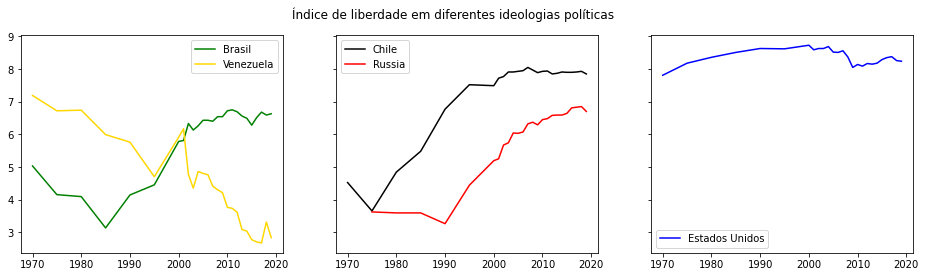

In [ ]:
findex = 'Economic Freedom Summary Index'
labels = ['Brazil', 'Venezuela, RB', 'Chile', 'Russian Federation', 'United States']
data = [df.loc[df.Countries == country][findex] for country in labels]
x = df.Year.unique()

fig, axs = plt.subplots(1, 3, figsize=(16,4), sharey=True)

axs[0].plot(x, data[0], color='green')
axs[0].plot(x, data[1], color='gold')
axs[0].legend(('Brasil', 'Venezuela'))

axs[1].plot(x, data[2], color='black')
axs[1].plot(x, data[3], color='red')
axs[1].legend(('Chile', 'Russia'))

axs[2].plot(x, data[4], color='blue')
axs[2].legend(('Estados Unidos',))

fig.suptitle('Índice de liberdade em diferentes ideologias políticas')
fig.show()

## Geografia da Liberdade

A primeira imagem indica em quais continentes estão localizados os países que figuram no top 100 da liberdade, tanto no ano mais recente de que se tem dados, quanto na média desde 1970.

A segunda imagem expõe o _boxplot_ do índice por continente, o que possibilita uma visão mais facilitada da mínima, máxima, média e _outliers_.

A terceira possibilita a pormenorização da visualização do índice por país no ano de 2019 enquanto a quarta, na média 1970-2019

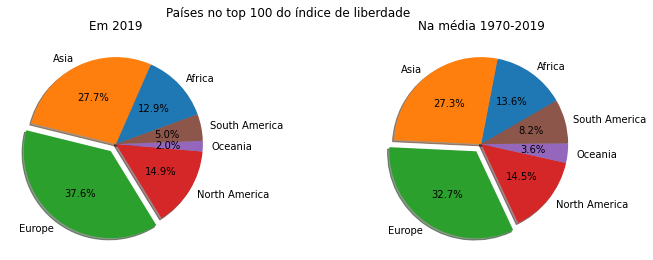

In [ ]:
data19 = df.loc[(df.Rank <= 100) & (df.Year == 2019)].groupby('Continent').count()['Countries']
data_mean = df.groupby('Countries').filter(lambda x: x['Rank'].mean() <= 100)
data_mean = data_mean.groupby('Continent').count()['Countries']

labels = sorted(df.Continent.unique())

fig, asx = plt.subplots(1,2, figsize=(12,4))
asx[0].pie(data19, labels=labels, explode=(0,0,0.1,0,0,0), shadow=True, autopct='%.1f%%', startangle=20)
asx[0].set_title('Em 2019')
asx[1].pie(data_mean, labels=labels, explode=(0,0,0.1,0,0,0), shadow=True, autopct='%.1f%%', startangle=30)
asx[1].set_title('Na média 1970-2019')
fig.suptitle('Países no top 100 do índice de liberdade')
fig.show()

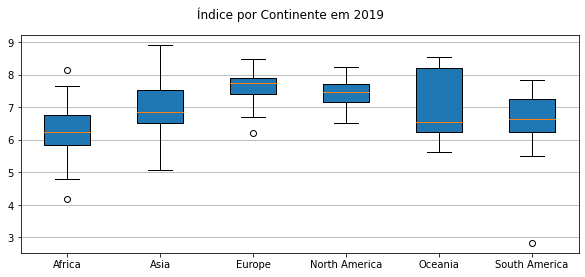

In [ ]:
data = [df.loc[(df.Continent == cont) & (df.Year == 2019)][findex] for cont in (
    'Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America')]

fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.boxplot(data, labels=labels, patch_artist=True)
ax.yaxis.grid(True)

fig.suptitle('Índice por Continente em 2019')
fig.show()

In [ ]:
data = dict(
    type = 'choropleth',
    locations = df.loc[df.Year == 2019]['ISO_Code_3'],
    colorscale = ['red', 'white', 'blue'],
    z = df.loc[df.Year == 2019][findex],
)

map = go.Figure(data=[data])
map.update_layout(width=600, height=400)
map.show()

In [ ]:
data_media = dict(
    type = 'choropleth',
    locations = df.loc[df.Year == 2019]['ISO_Code_3'],
    colorscale = ['red', 'white', 'blue'],
    z = [df.loc[df.Countries == country][findex].mean() for country in df.Countries.unique()]
)

map = go.Figure(data=[data_media])
map.update_layout(width=600, height=400)
map.show()

## Brasil vs Mundo

Os próximos gráficos fazem comparações dos índices entre o Brasil e os países que compõem o G7; e entre o Brasil e os demais países da América do Sul, tanto na média quanto no ano de 2019.

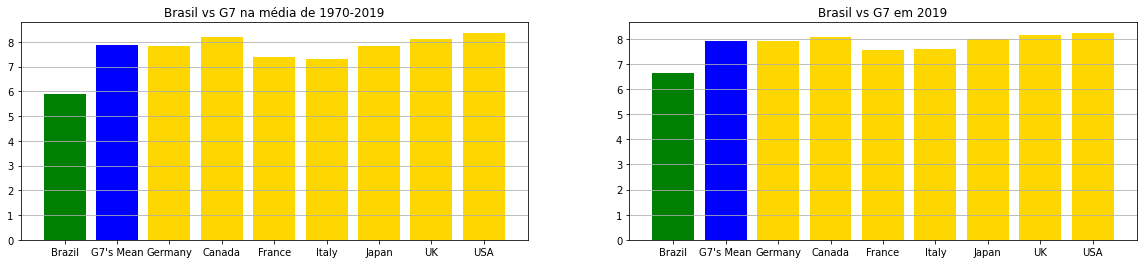

In [ ]:
labels = ['Brazil', 'Germany', 'Canada', 'France', 'Italy', 'Japan', 'United Kingdom', 'United States']

media_g7_19 = np.array([df.loc[(df.Countries == country) & (df.Year == 2019)][findex].values[0] for country in labels[1:]]).mean()
g7_19 = [df.loc[(df.Countries == country) & (df.Year == 2019)][findex].values[0] for country in labels]
g7_19.insert(1, media_g7_19)

media_media = np.array([df.loc[df.Countries == country][findex].mean() for country in labels[1:]]).mean()
g7_media = [df.loc[df.Countries == country][findex].mean() for country in labels]
g7_media.insert(1, media_media)

labels = [labels[0]] + ["G7's Mean"] + labels[1:-2] + ['UK', 'USA']

fig, axs = plt.subplots(1,2, figsize=(20,4))
axs[1].yaxis.grid(True)
axs[1].bar(labels, g7_19, color=['green','blue'] + ['gold'] * 7)
axs[1].set_title('Brasil vs G7 em 2019')
axs[0].yaxis.grid(True)
axs[0].bar(labels, g7_media, color=['green','blue'] + ['gold'] * 7)
axs[0].set_title('Brasil vs G7 na média de 1970-2019')

fig.show()

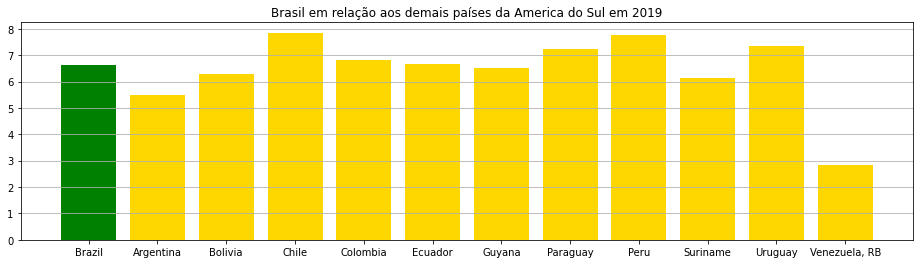

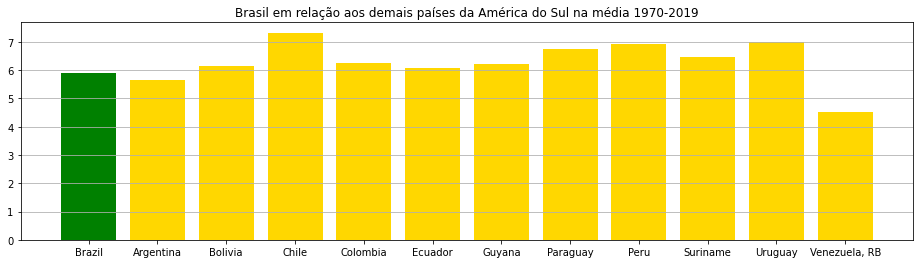

In [ ]:
south_america = df.loc[(df.Continent == 'South America') & (df.Countries != 'Brazil')]['Countries'].unique()
labels = ['Brazil', *south_america]
south_mean = [df.loc[df.Countries == country][findex].mean() for country in labels]
south_19 = [df.loc[(df.Countries == country) & (df.Year == 2019)][findex].values[0] for country in labels]

fig, axs = plt.subplots(1,1, figsize=(16,4))
axs.bar(labels, south_19, color=['green'] + ['gold'] * 11)
axs.yaxis.grid(True)
axs.set_title('Brasil em relação aos demais países da America do Sul em 2019')
fig.show()

fig, axs = plt.subplots(1,1, figsize=(16,4))
axs.bar(labels, south_mean, color=['green'] + ['gold'] * 11)
axs.yaxis.grid(True)
axs.set_title('Brasil em relação aos demais países da América do Sul na média 1970-2019')
fig.show()